# News Forensics using K-Means/DBSCAN Clustering and LDA/LSA Topic Modelling using NLP Techniques
## Dataset: 'A Million News Headlines by ABC News'

## Author: Muhammad Talal Faiz




# Preparation & Initial Exploratory Data Analysis
##**Context**
The datatset contains a corpus of news headlines posted over a period of almost two decades. Combing through the data the oldest recorded headline is from 19th of February, 2003 and the latest headline is 31st of December 2021. The headlines are all from the same source that is the Australian Broadcasting Corporation abbreviated ABC News. The focus of the dataset is on Australia and as shown below its keywords suggest a good focus on International News for example involving the Iraq War and Elections in the US.
##**Content**
Format: CSV Single File
It has two columns
  1. publish_date: date headline was published in yyyyMMdd format
  2. headline_text: Headline Text in ASCII English Lowercase

### Importing Dataset
Our first step involves importing the dataset using pandas read_csv() function and parsing the date column as dates while automatically inferring the yyyMMdd date format

In [1]:
import pandas as pd
df=pd.read_csv('/content/abcnews-date-text.csv',parse_dates=[0],infer_datetime_format=True)
print(df)
df.info()

        publish_date                                      headline_text
0         2003-02-19  aba decides against community broadcasting lic...
1         2003-02-19     act fire witnesses must be aware of defamation
2         2003-02-19     a g calls for infrastructure protection summit
3         2003-02-19           air nz staff in aust strike for pay rise
4         2003-02-19      air nz strike to affect australian travellers
...              ...                                                ...
1244179   2021-12-31  two aged care residents die as state records 2...
1244180   2021-12-31  victoria records 5;919 new cases and seven deaths
1244181   2021-12-31    wa delays adopting new close contact definition
1244182   2021-12-31  western ringtail possums found badly dehydrate...
1244183   2021-12-31  what makes you a close covid contact here are ...

[1244184 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244184 entries, 0 to 1244183
Data columns (total 2 column

### Cleaning Dataset
Now we can start our dataset cleansing. First we will look for any missing entries in our dataset

In [2]:
raw_df=df.copy()
MissingValues=raw_df.isnull()

print(f'Total Number of Missing Values \n{MissingValues.sum()}')

Total Number of Missing Values 
publish_date     0
headline_text    0
dtype: int64


Then we will look for duplicate entries of the same headlines on the same day. Because similar headlines on different days may be relaying different news and can affect the probability of modelling a certain topic

In [3]:

duplicate_df=raw_df.copy()
duplicate_df['cleaned_headline'] = duplicate_df['headline_text'].str.lower().str.strip()
duplicate_df['is_duplicate']=duplicate_df.duplicated(['cleaned_headline','publish_date'],keep=False)
duplicate_df[duplicate_df['is_duplicate']]


publish_date                                     headline_text  \
662094    2011-12-23              the search for sheep price stability   
662095    2011-12-23             the search for sheep price stability    
1232753   2021-03-01  house prices record sharpest increase since 2003   
1232754   2021-03-01  house prices record sharpest increase since 2003   
1237049   2021-06-01    house prices reach record levels; as investors   
1237050   2021-06-01    house prices reach record levels; as investors   

                                         cleaned_headline  is_duplicate  
662094               the search for sheep price stability          True  
662095               the search for sheep price stability          True  
1232753  house prices record sharpest increase since 2003          True  
1232754  house prices record sharpest increase since 2003          True  
1237049    house prices reach record levels; as investors          True  
1237050    house prices reach record levels; as investors          True

Now as we can see above our dataset is of a very high quality with only 3 duplicate headlines hence we will now update our raw dataframe as per

In [4]:
cleaned_raw_df=raw_df.copy()
cleaned_raw_df['cleaned_headline'] = cleaned_raw_df['headline_text'].str.lower().str.strip()
cleaned_raw_df=cleaned_raw_df.drop_duplicates(['cleaned_headline','publish_date'],keep='first')
cleaned_raw_df.head()


publish_date                                      headline_text  \
0   2003-02-19  aba decides against community broadcasting lic...   
1   2003-02-19     act fire witnesses must be aware of defamation   
2   2003-02-19     a g calls for infrastructure protection summit   
3   2003-02-19           air nz staff in aust strike for pay rise   
4   2003-02-19      air nz strike to affect australian travellers   

                                    cleaned_headline  
0  aba decides against community broadcasting lic...  
1     act fire witnesses must be aware of defamation  
2     a g calls for infrastructure protection summit  
3           air nz staff in aust strike for pay rise  
4      air nz strike to affect australian travellers

So we have reduced our total entries from 1244184 to 1244181 successfully removing the 3 duplicates

Next we have to reindex our data so that we can use the published date to identify the headlines rather than the Autonumber assigned by pandas. By doing so it will be helpful to us when we perform our Temporal Analysis

In [5]:
dateindex_df = cleaned_raw_df.copy()
dateindex_df.index = cleaned_raw_df['publish_date']
dateindex_df = dateindex_df.drop(columns=['publish_date'])
dateindex_df.head()

headline_text  \
publish_date                                                      
2003-02-19    aba decides against community broadcasting lic...   
2003-02-19       act fire witnesses must be aware of defamation   
2003-02-19       a g calls for infrastructure protection summit   
2003-02-19             air nz staff in aust strike for pay rise   
2003-02-19        air nz strike to affect australian travellers   

                                               cleaned_headline  
publish_date                                                     
2003-02-19    aba decides against community broadcasting lic...  
2003-02-19       act fire witnesses must be aware of defamation  
2003-02-19       a g calls for infrastructure protection summit  
2003-02-19             air nz staff in aust strike for pay rise  
2003-02-19        air nz strike to affect australian travellers

Now we are going to explore the actual content of the dataset itself we will start by looking at the recurring prominent keywords across the whole corpus that would allow us to judge what were the main headlines over the past two decades. This will be helpful for us when we get to validate the results of our Topical Modelling

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

### Exploring Dataset Content

For this task we are going to use CountVectorizer a feature extraction tool that cleans our corpus's individual headlines and then identifies the Unique Words in the entire corpus it will then return us a Sparse Matrix with entries of the counts of each unique word across each Headline in our corpus. Moreover it also will filter out the stop words we use in english such as 'a' 'the' 'at'. These are of no interest to us and contribute no information in analysing our corpus as well as punctuations.

Note: Our matrix will be sparse because many Unique Words may not occur more than once across the entire corpus.

**But apart from using the CountVectorizer we have to also use a stemmer to find the root words throughout all headlines. For example: Jobs root word is Job this will help us reduce our feature space when we go on to apply some of our algorithms and also it makes sure our model only deals with core word meanings of the headlines not every plural or singular form**

In [7]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from concurrent.futures import ThreadPoolExecutor
import string
import nltk

nltk.download('stopwords')
snowball_stemmer = SnowballStemmer("english")
def stem_headline(Headline):
    return " ".join([snowball_stemmer.stem(word) for word in Headline.split()])
stop_words_nltk = set(stopwords.words('english'))
stop_words_custom = list(stop_words_nltk.union(set(string.punctuation)))
Vectorizer = CountVectorizer(stop_words=stop_words_custom)
dateindex_df['stemmed_headline'] = dateindex_df['cleaned_headline'].apply(stem_headline)
Headlines=dateindex_df['cleaned_headline'].values
#Stemmed_Headlines = [" ".join([snowball_stemmer.stem(word) for word in Headline.split()]) for Headline in Headlines]

Vectorized_Headlines=Vectorizer.fit_transform(Headlines)
Vocabulary=Vectorizer.get_feature_names_out()
Word_Counts=Vectorized_Headlines.sum(axis=0)



dateindex_df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


headline_text  \
publish_date                                                      
2003-02-19    aba decides against community broadcasting lic...   
2003-02-19       act fire witnesses must be aware of defamation   
2003-02-19       a g calls for infrastructure protection summit   
2003-02-19             air nz staff in aust strike for pay rise   
2003-02-19        air nz strike to affect australian travellers   

                                               cleaned_headline  \
publish_date                                                      
2003-02-19    aba decides against community broadcasting lic...   
2003-02-19       act fire witnesses must be aware of defamation   
2003-02-19       a g calls for infrastructure protection summit   
2003-02-19             air nz staff in aust strike for pay rise   
2003-02-19        air nz strike to affect australian travellers   

                                          stemmed_headline  
publish_date                                                
2003-02-19    aba decid against communiti broadcast licenc  
2003-02-19              act fire wit must be awar of defam  
2003-02-19       a g call for infrastructur protect summit  
2003-02-19        air nz staff in aust strike for pay rise  
2003-02-19       air nz strike to affect australian travel

As seen above we used a combination of the fit and transform functions. Fit to analyse our corpus and 'learn' all the unique vocabulary and transform to convert each headline in our corpus to a vector with values that represent the counts of any of the words in the vocabulary

**Note: 'Learn' here doesn't mean learning as in ML**

So we have performed our initial cleaning and exploring of the content of our data but now we need to know the density or sparsity of our data samples with respect to certain features. One of the features used for finding our sample density will be tagged part-of-speech (further explained below) and the length of our headlines. Inaddition we will also be checking our sample density with respect to time (Weekly, Monthly, Yearly). This will be useful when we conduct our topical analysis over time later on. We will also be looking at Frequent Words to validate our topical modelling results

First we are going to look at the overall most occurring words so that when we can validate our findings from when we perform our Topical Modelling using LSA or LDA and perform comparisons between them.

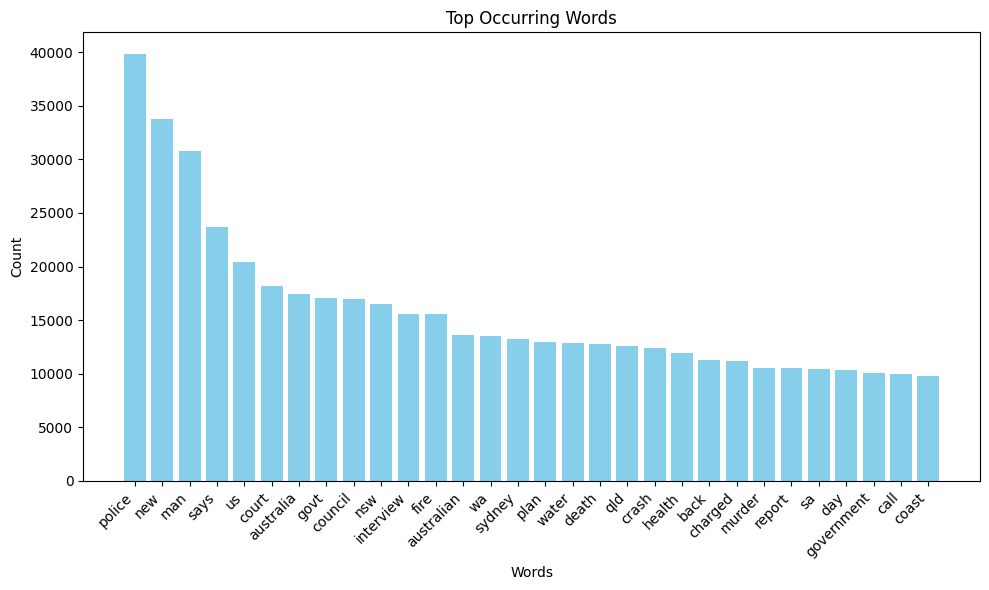

In [8]:
import matplotlib.pyplot as plt
top_words_df=pd.DataFrame({'Word':Vocabulary,'Count':Word_Counts.flat})
top_words_df = top_words_df.sort_values(by='Count', ascending=False)
top_words_df = top_words_df.head(30)
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['Word'], top_words_df['Count'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top Occurring Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Next lets take a look at the sample density with time

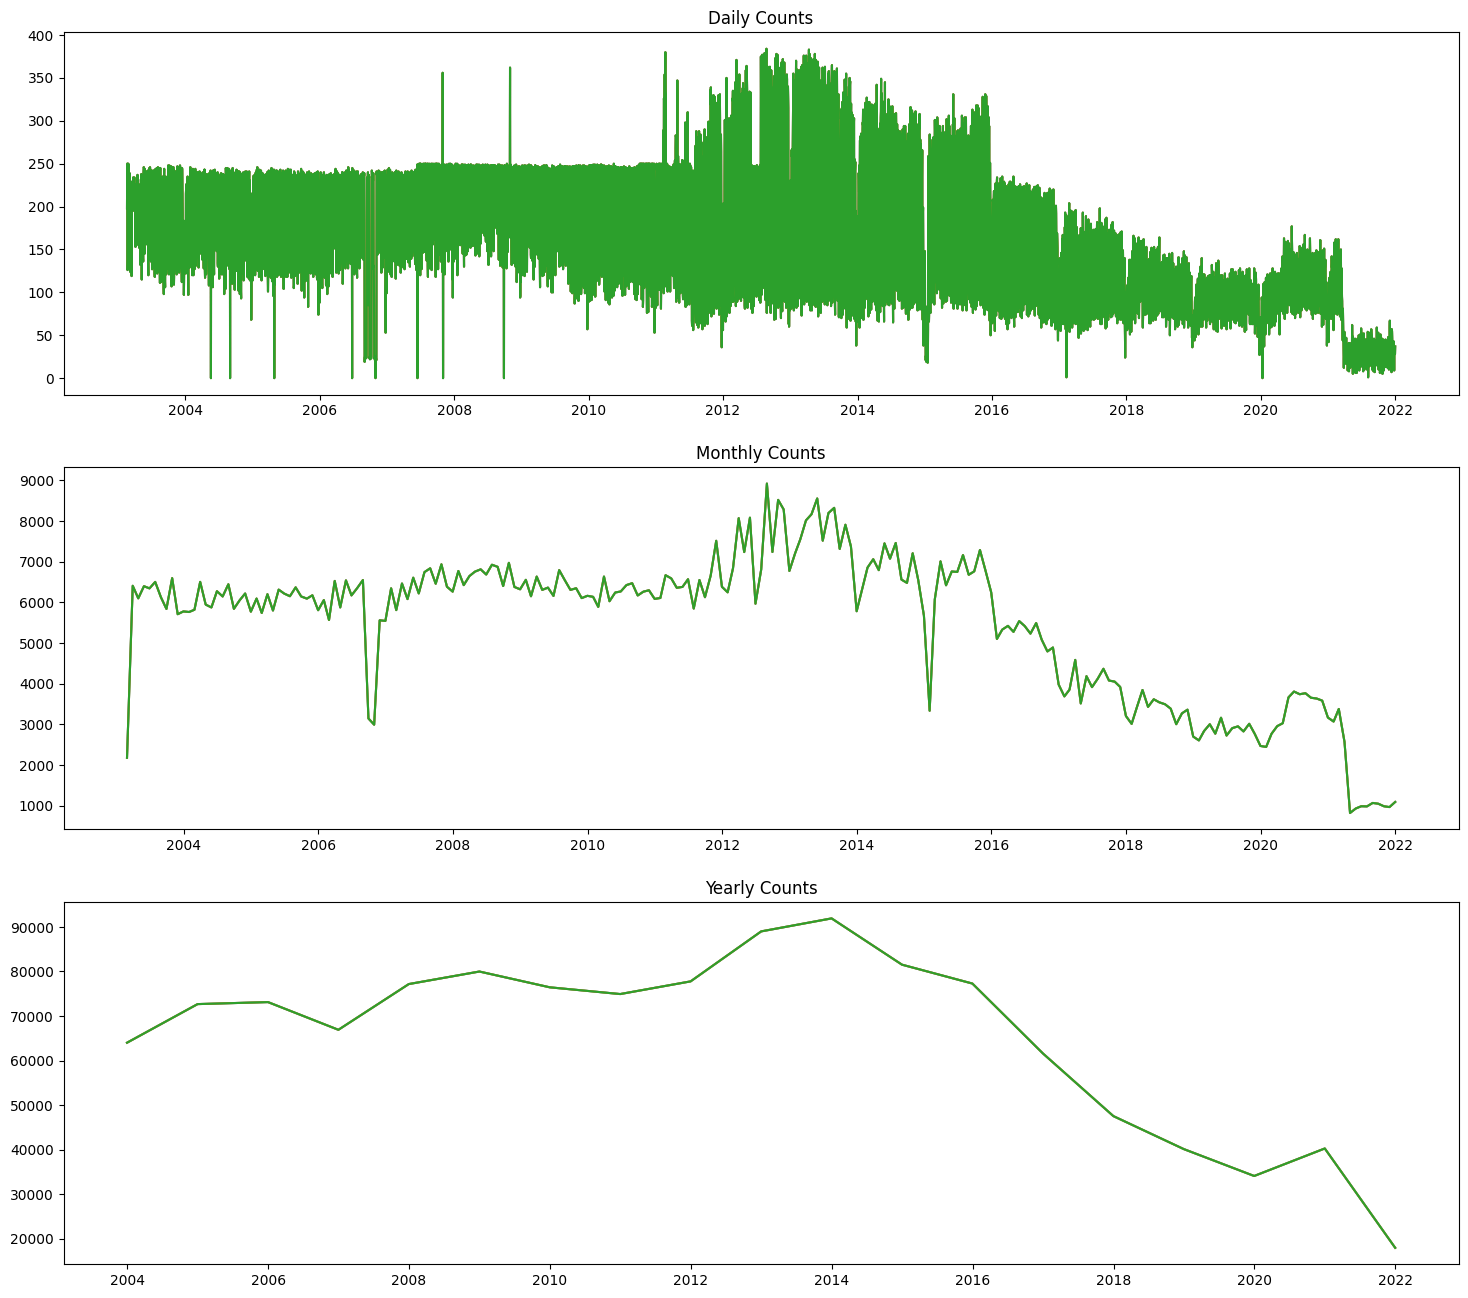

In [9]:
monthly_counts = dateindex_df.resample('M').count()
yearly_counts = dateindex_df.resample('A').count()
daily_counts = dateindex_df.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
ax[2].plot(yearly_counts);
ax[2].set_title('Yearly Counts');
plt.show()

The overall trend our dataset shows that the major amount of samples are from 2012-2016 and before that from 2004-2011 it has a constant amount of samples albeit lower counts with respect to each day, month and year and finally we have a decreasing amount of counts from 2017-2020 with a small spike in 2020-2021 because of COVID and the final decline in counts towards the end since we dont have headlines from 2022

Then we will look at Part-Of-Speech taggings with respect to the entire corpus so that we can check for any errors that may have occured during our tokenization, visualise the overall style of our headlines and we will also be able to use it for enhancing the LDA/LSA results respectively by filtering our dataset so that only the most meaningful parts of speech i.e: Nouns and Verbs are included in our final Sparse Matrix

In [10]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from textblob import TextBlob
tagged_words = [TextBlob(word).tags for word in Vocabulary]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The foremost thing we do is convert each one of our headlines into a Text Blob object. Textblob is one of the best libraries used to perform text analysis or NLP tasks suchas P-O-S, Classification, Sentiment Analysis etc. It is easy to use and beginner friendly hence our choice. It is built ontop of the NLTK and a text blob object can call methods to analyse text such as in our case the P-O-S tagging.


[[('00', 'CD')], [('000', 'CD')], [('000km', 'CD')], [('002', 'CD')], [('005', 'CD')], [('006', 'CD')], [('007', 'CD')], [('01', 'CD')], [('0101', 'CD')], [('0103', 'CD')], [('0105', 'CD')], [('0106', 'CD')], [('010615', 'CD')], [('0107', 'CD')], [('010715', 'CD')], [('0108', 'CD')], [('010814', 'CD')], [('0109', 'CD')], [('0110', 'CD')], [('0111', 'CD')], [('011114', 'CD')], [('0112', 'CD')], [('011214', 'CD')], [('013', 'CD')], [('0130', 'CD')], [('014', 'CD')], [('0156', 'CD')], [('0161', 'CD')], [('0179', 'CD')], [('018', 'CD')], [('01am', 'CD')], [('01pc', 'CD')], [('02', 'CD')], [('0201', 'CD')], [('0202', 'CD')], [('020215', 'CD')], [('0204', 'CD')], [('0205', 'CD')], [('0206', 'CD')], [('020615', 'CD')], [('0207', 'CD')], [('020715', 'CD')], [('02072021', 'CD')], [('0208', 'CD')], [('0209', 'CD')], [('0210', 'CD')], [('021014', 'CD')], [('0211', 'CD')], [('0212', 'CD')], [('021214', 'CD')], [('0214', 'CD')], [('0216', 'CD')], [('0241', 'CD')], [('0257', 'CD')], [('026pc', 'CD')

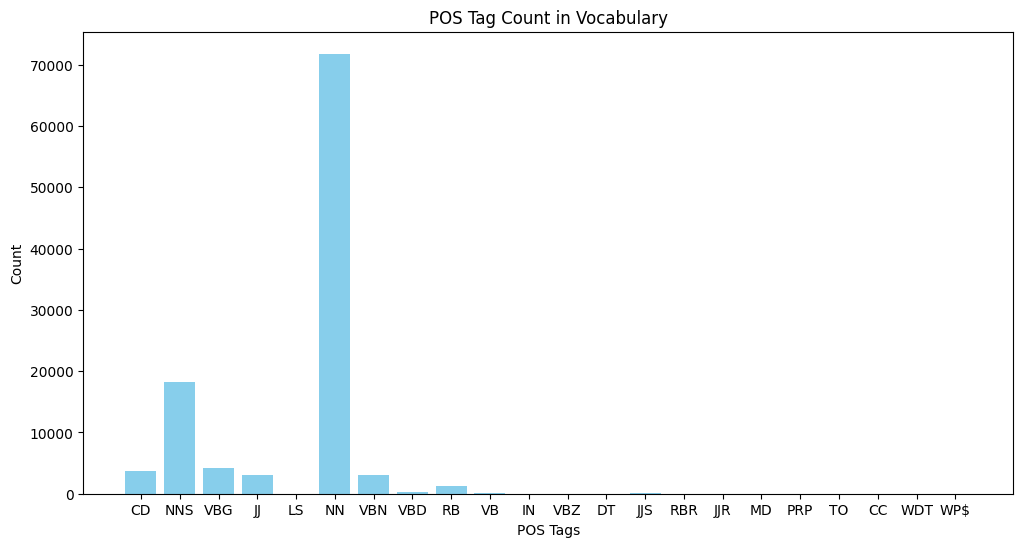

In [11]:
from collections import Counter
print(tagged_words)
all_tags = [tag for tags in tagged_words for _, tag in tags]
tag_counts = Counter(all_tags)

plt.figure(figsize=(12, 6))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.xlabel('POS Tags')
plt.ylabel('Count')
plt.title('POS Tag Count in Vocabulary')
plt.show()

Our findings above show that we have the following prominent categories in our dataset:
1. NN: Nouns Singular
2. NNS: Nouns Plural
3. VBG: Verbs present participle
4. VBN: VERBS
5. VBD: VERBS
6. RB: Adverbs
7. CD: Cardinal Numbers
8. JJ: Adjectives

In our topical modelling the most useful categories will be NN, NNS, All Verbs

In [12]:
import numpy as np
from scipy.sparse import csr_matrix
def filter_nouns_and_verbs(tags):
    filtered_words = [word for word, tag in tags if tag.startswith('N') or tag.startswith('V')]
    return filtered_words if filtered_words else None

filtered_words = [filter_nouns_and_verbs(tags)[0] for tags in tagged_words if filter_nouns_and_verbs(tags)]
print(filtered_words)

filtered_words_set = set(filtered_words)
filtered_indices = [i for i, word in enumerate(Vocabulary) if word in filtered_words_set]
filtered_vocabulary=[word for word in Vocabulary if word in filtered_words_set]

filtered_sparse_matrix = Vectorized_Headlines[:, filtered_indices]
POSFilteredHeadlines=filtered_sparse_matrix

top_words_df = pd.DataFrame({'Word': Vocabulary[filtered_indices], 'Count': filtered_sparse_matrix.sum(axis=0).flat})


['10000th', '1000th', '100th', '104th', '105th', '107th', '108th', '10th', '110th', '117th', '120th', '125th', '127th', '134th', '140th', '14th', '150th', '154th', '1570s', '15th', '15years', '160th', '170th', '1750s', '175th', '178th', '17th', '1840s', '1850s', '1860s', '18th', '1940s', '1950s', '1960s', '1970s', '19testing', '1in5muslims', '30ths', '360s', '36ers', '3months', '49ers', '4corners', '4farmers', '4senses', '50million', '55th', '5th', '60s', '6million', '700th', '70s', '70th', '730grams', '750th', '755th', '75th', '76ers', '78ers', '7th', 'a1', 'a110', 'a14m', 'a19', 'a1s', 'a2', 'a320', 'a330', 'a350', 'a380', 'a380s', 'a4', 'a400m', 'a5', 'a54b', 'a57b', 'a5m', 'a65', 'a9', 'aa', 'aa1', 'aa2', 'aa2b', 'aaa', 'aaahhh', 'aaas', 'aac', 'aacc', 'aaco', 'aacos', 'aacta', 'aactas', 'aad', 'aadhaar', 'aadmi', 'aads', 'aag', 'aagaard', 'aagard', 'aah', 'aalto', 'aam', 'aamer', 'aamers', 'aami', 'aamodt', 'aandahl', 'aant', 'aap', 'aapa', 'aaps', 'aapt', 'aaradhna', 'aardman', '

Now lets have a final look at our topmost occuring words

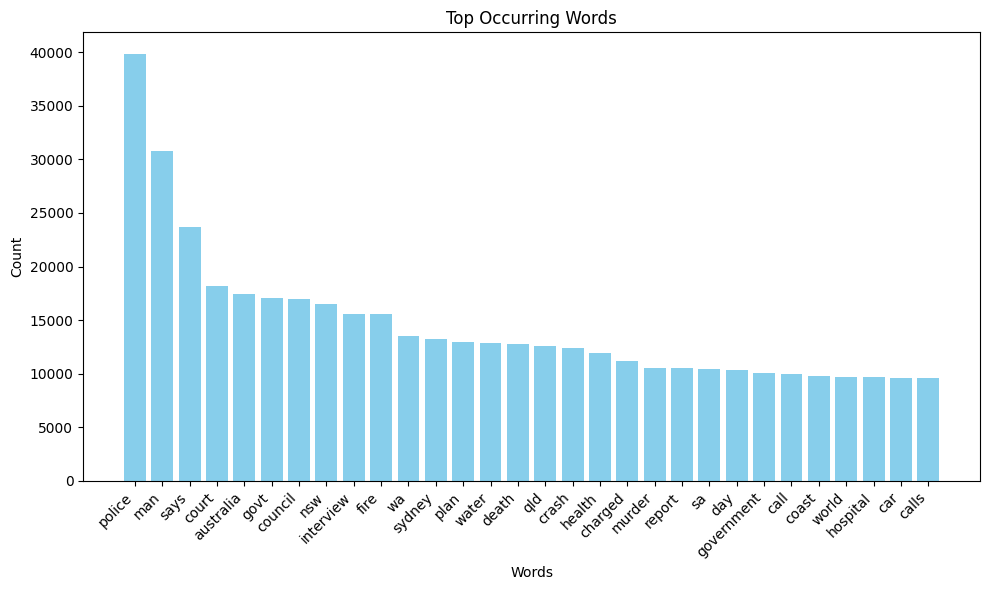

In [13]:

top_words_df = top_words_df.sort_values(by='Count', ascending=False)
top_words_df = top_words_df.head(30)
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['Word'], top_words_df['Count'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top Occurring Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Finally we will look at the average headline length to identify any outliers

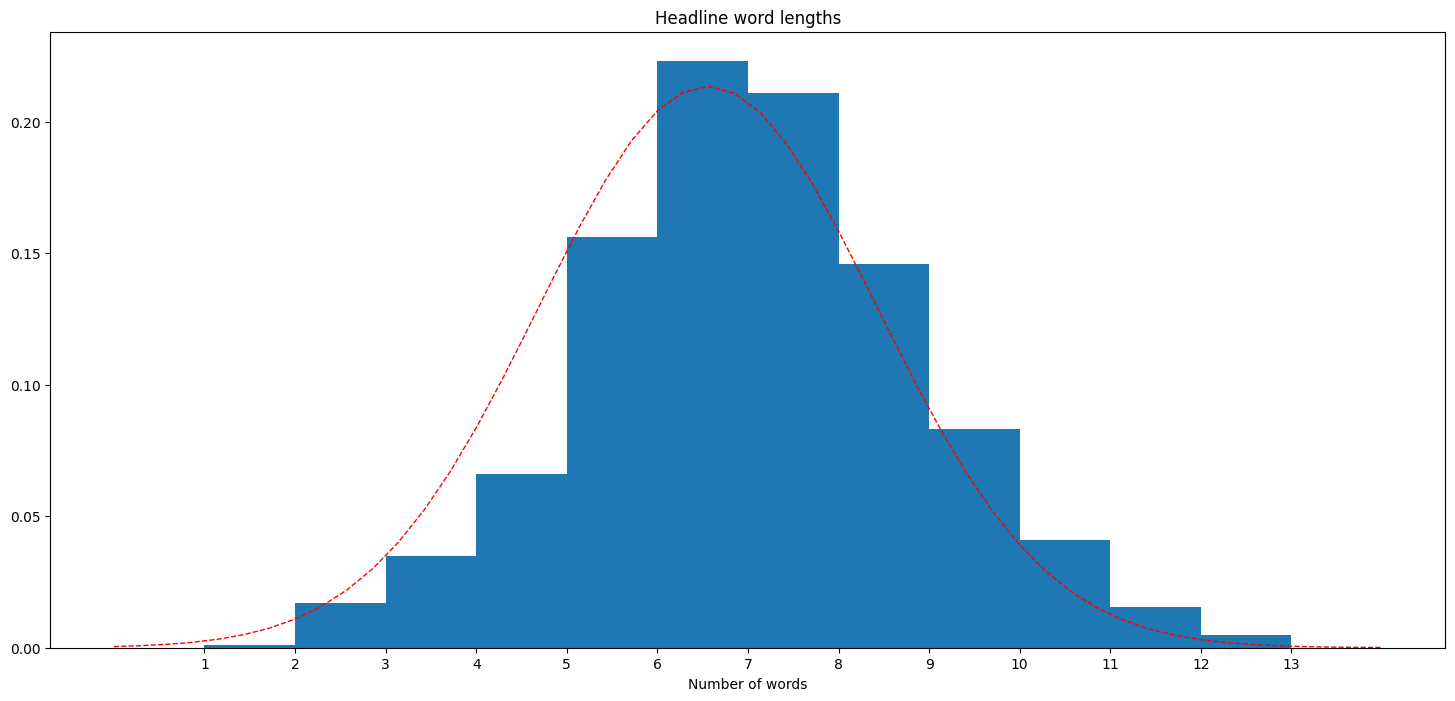

Total number of words:  8158745
Mean number of words per headline:  6.557522579110274


In [14]:
import scipy.stats as stats
word_counts = []
for headline in Headlines:
    word_counts.append(len(headline.split()))
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Finally we have done all our Exploratory Data Analysis. We have prepared our dataset accordingly and made changes where necessary now we can move onto the next step which is the actual training of our model and evaluation of it's results

# Topical Modelling
##**GOAL**

The core of our project involves using the results of Topical Modelling as a basis to perform analyses on our headlines dataset to extract conclusions on what happened in the past 2 decades but this all must be done on subsets of data that contain the different topics that were the themes of our past two decades, and prior to all of this we need to find the topical modelling algorithm that gives us the best results and the two contenders we have now are:
1. Latent Dirchelt Allocation (LDA)
2. Latent Semantic Analysis (LSA)

##**METRICS**

Visualise and Compare results using Cluster Plots, Word Clouds etc. then go on to perform analysis over the results like heatmap, geomaps etc.

##**PROBLEMS**

**However moving further we have a very simple problem. Choosing between pre-process clustering or post-process clustering. There are multiple reasonings for this.**

Reasons for Pre-processing:
1. Targeted Analysis of specific clusters related to specific event can be done using the clusters already made beforehand
2. More specific and coherent topics are returned if we do topical modelling after clustering
3. Choose different parameters for the topical modelling algorithm we use for each clustering making sure it is the most suitable for that cluster

Reasons for Post-Processing:
1. Gain the Global Context as there maybe topics/themes that could span multiple clusters
2. Gain a comprehensive understanding and maybe uncover some unexpected trend
3. The entire nature of our dataset is not known before hand. Our EDA suggests that we have all sorts of news it is a mixture of topics hencue using post-processing we will have an Unsupervised discovery of each topic whereas in Pre-Processing we will lose this aspect as we will supervise and limit our working clusters

Furthermore we have to decide between DBSCAN and K-Means as our pre/post processing clustering algorithms

And at the end we will create a function which will take as input a recent headline and predict it's topical group as well as other related headlines from past

## Experimental Workflow






###   1. Experimenting with LSA & LDA
    


#### LDA
As shown below we are going to be applying LDA to a small subset of our dataset to find out how well it is working out. To that end we will look at the recognised topics and then we will also plot each topic with respect to its no of headlines using t-SNE (t-distributed Stochastic Neighbour Embedding). It will cause dimensionality reduction allowing us to plot of our results on scatterplot

The result of lda is a document-topic matrix what it does is take the document-term matrix and change it so that each row is a document/headline and each column is a topic and the entries are the probabilities that one of those topics is dominant in the headlines.

Next we will visualise what each one of the topics are and what are their respective headline counts from initial subset of the entire dataset we looked at

Our second visualisation will show how well distinct our topics are and how well the clusters are separated

Next we make a word cloud showing all the Named Entities involved in each one of the Topical Clusters

Finally the desired heatmap for the each topic over the years is made by using the random fraction of the entire data and running LDA on it and the coherence score for the model is shown



Combining it all we can create an Interactive Widget that changes the num of topics and training set size and visualise the respective results

In [15]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
import spacy
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
nlp = spacy.load("en_core_web_sm")


shuffled_indices = shuffle(cleaned_raw_df.index)

from ipywidgets import interact, widgets
from IPython.display import display





def visualize_lda(subset_size, num_words_per_topic, num_topics):
    subset_matrix = filtered_sparse_matrix[shuffled_indices[:subset_size]]


    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_result = lda_model.fit_transform(subset_matrix)


    feature_names = filtered_vocabulary
    for topic_idx, topic in enumerate(lda_model.components_):
        top_word_indices = np.argsort(topic)[::-1][:num_words_per_topic]
        top_words = [feature_names[index] for index in top_word_indices]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")



    dominant_topic = np.argmax(lda_result, axis=1)
    topic_df = pd.DataFrame({'dominant_topic': dominant_topic}, index=shuffled_indices[:subset_size])


    topic_counts = topic_df.groupby('dominant_topic').size().reset_index(name='count')
    plt.figure(figsize=(12, 6))
    plt.bar(topic_counts['dominant_topic'] + 1, topic_counts['count'], color='skyblue')
    plt.xlabel('Dominant Topic')
    plt.ylabel('Number of Headlines')
    plt.title('Headline Counts by Dominant Topic')
    plt.show()


    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(lda_result)
    plt.figure(figsize=(10, 8))
    for i in range(num_topics):
        indices = np.where(lda_result.argmax(axis=1) == i)[0]
        plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=f'Topic {i + 1}')
    plt.title('t-SNE Visualization of LDA Topics')
    plt.legend()
    plt.show()

    topic_df['publish_year'] = cleaned_raw_df['publish_date'].dt.year
    topic_counts = pd.crosstab(topic_df['dominant_topic'] + 1, topic_df['publish_year'])
    topic_percentages = topic_counts.div(topic_counts.sum(axis=0), axis=1) * 100
    plt.figure(figsize=(12, 8))
    sns.heatmap(topic_percentages, cmap='viridis', annot=False, fmt=".2f", linewidths=.5)
    plt.title('Topic Evolution Across Years (Subset Size = 1000)')
    plt.xlabel('Year')
    plt.ylabel('Topic')
    plt.show()


    num_words_per_topic = 100
    top_words_per_topic = []
    all_named_entities_per_topic=[]
    for topic_word_distribution in lda_model.components_:
        top_word_indices = topic_word_distribution.argsort()[::-1][:num_words_per_topic]
        top_words = [feature_names[index] for index in top_word_indices]

        named_entities = []
        for word in top_words:
          doc = nlp(word)
          for ent in doc.ents:
            named_entities.append(ent.text)
        top_words_per_topic.append(top_words)
        all_named_entities_per_topic.append(named_entities)
    for i, top_words in enumerate(top_words_per_topic):
        named_entities = all_named_entities_per_topic[i]
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(named_entities))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {i + 1} Word Cloud')
        plt.show()



interact(visualize_lda,
         subset_size=widgets.IntSlider(min=100, max=len(cleaned_raw_df), step=100, value=1000),
         num_words_per_topic=widgets.IntSlider(min=2, max=50, step=1, value=10),
         num_topics=widgets.IntSlider(min=2, max=10, step=1, value=5))


interactive(children=(IntSlider(value=1000, description='subset_size', max=1244181, min=100, step=100), IntSli…

<function __main__.visualize_lda(subset_size, num_words_per_topic, num_topics)>